In [37]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import networkx as nx
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from os import listdir
from os.path import isfile, join

In [38]:
# NUMBER_NODES = 9
NUMBER_NODES = 7
# NUMBER_NODES = 5

def load_data():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        f'./graphs_{NUMBER_NODES}',
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(64, 64),
        batch_size=32)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        f'./graphs_{NUMBER_NODES}',
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(64, 64),
        batch_size=32)
    return train_ds, val_ds

In [39]:
train_ds, val_ds = load_data()

Found 940 files belonging to 448 classes.
Using 752 files for training.
Found 940 files belonging to 448 classes.
Using 188 files for validation.


In [40]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(256, 256, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

class_names = train_ds.class_names
num_classes = len(class_names)

model = models.Sequential()
# model.add(data_augmentation)
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes))

model.compile(optimizer='adam',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=128,
)

Epoch 1/128
24/24 [==============================] - 10s 307ms/step - loss: 6.0607 - accuracy: 0.0731 - val_loss: 5.9593 - val_accuracy: 0.1011
Epoch 2/128
24/24 [==============================] - 6s 255ms/step - loss: 5.8277 - accuracy: 0.0984 - val_loss: 6.0415 - val_accuracy: 0.1011
Epoch 3/128
24/24 [==============================] - 7s 270ms/step - loss: 5.6668 - accuracy: 0.0984 - val_loss: 6.1922 - val_accuracy: 0.1011
Epoch 4/128
24/24 [==============================] - 6s 261ms/step - loss: 5.5883 - accuracy: 0.0984 - val_loss: 6.2299 - val_accuracy: 0.1011
Epoch 5/128
24/24 [==============================] - 6s 250ms/step - loss: 5.5316 - accuracy: 0.0984 - val_loss: 6.4138 - val_accuracy: 0.1011
Epoch 6/128
24/24 [==============================] - 7s 265ms/step - loss: 5.5083 - accuracy: 0.0984 - val_loss: 6.5208 - val_accuracy: 0.1011
Epoch 7/128
24/24 [==============================] - 7s 265ms/step - loss: 5.4817 - accuracy: 0.0984 - val_loss: 6.5314 - val_accuracy: 0.101

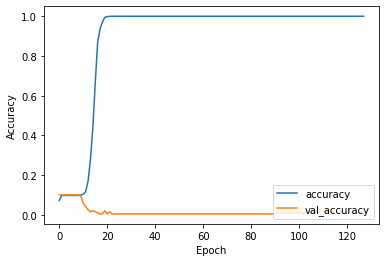

In [41]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [42]:
model.save('CNN_dir_model')

INFO:tensorflow:Assets written to: CNN_dir_model\assets


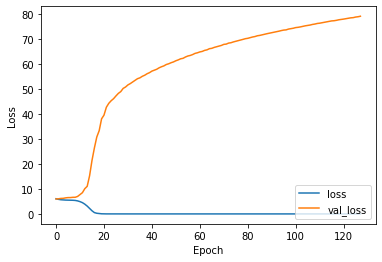

In [43]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [44]:
def load_img(image_filename):
    image_input = tf.keras.preprocessing.image.load_img(f'./teste_images/{image_filename}')
    image_input_arr = tf.keras.preprocessing.image.img_to_array(image_input)
    image_input_np = np.array(image_input_arr)
    image_input_np = image_input_np / 255.0
    image_input_np = tf.image.resize(image_input_np, [256, 256])
    return image_input_np

# images = [file for file in listdir(f'./test_graphs_{NUMBER_NODES}') if isfile(join(f'./test_graphs_{NUMBER_NODES}', file))]

# test_images = []
# for image in images:
#     img = load_img(image)
#     test_images.append(img)
# test_images = np.array(test_images)

In [45]:
# test_ds = tf.keras.utils.image_dataset_from_directory(
#         f'./test_graphs_{NUMBER_NODES}',
#         seed=123,
#         image_size=(256, 256),
#         batch_size=32)

In [46]:
def get_bandwidth_nn_output(Graph, nodelist):
    Graph = nx.Graph(Graph)
    if not Graph.edges:
        return 0
    L = nx.laplacian_matrix(Graph, nodelist=nodelist)
    x, y = np.nonzero(L)
    return (x-y).max()

def processDataToImage(graphInput):
    graph_adj = getGraph(graphInput)
    graph = nx.Graph(graph_adj)

    nx.draw(graph, with_labels=True)
    plt.savefig(f'./Graph_input.png')
    plt.clf()
    image_input = tf.keras.preprocessing.image.load_img(f'./Graph_input.png')
    image_input_arr = tf.keras.preprocessing.image.img_to_array(image_input)
    image_input_np = image_input_arr / 255.0

    image_input_np = tf.image.resize(image_input_np, [64, 64])
    return image_input_np

def getGraph(upperTriangleAdjMatrix):
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    k = 0
    for i in range(NUMBER_NODES):
        for j in range(NUMBER_NODES):
            if i == j:
                continue
            elif i < j:
                dense_adj[i][j] = upperTriangleAdjMatrix[k]
                k += 1
            else:
                dense_adj[i][j] = dense_adj[j][i]
    return dense_adj

def getArray(strArray):
    arr = strArray.split('.')
    first = strArray[1]
    arr = [first, *arr[1 : -1]] # skip '[' and ']'
    arr = list(map(lambda x: int(x.strip()), arr))
    return arr
    
def load_test_data():
    NUMBER_NODES=7
    df = pd.read_csv(f'./test_graphs_{NUMBER_NODES}/teste_data_{NUMBER_NODES}.csv')
    print(df.shape)

    featuresNumber = ((NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 )
    features = df.iloc[ : , : featuresNumber ].values
    labels = df.iloc[ : , featuresNumber + 1 : ].values # skip bandwidth value
    return features, labels

In [47]:
test_features, test_labels = load_test_data()

(104, 29)


In [48]:
sumTest_pred = 0
sumTest_true = 0

for x, true in zip(test_features, test_labels):
    get_graph_image_arr = processDataToImage(x)
    print("FELIPE")
    print(get_graph_image_arr.shape)
    pred = model.predict(np.array([get_graph_image_arr]))
    print("===")
    try:
        print(np.argmax(pred))
        print(class_names.index(str(true)))
    except ValueError:
        print(f"{str(true)} not in class_names")
    
    print("as node list:")
    str_pred_nodelist = class_names[np.argmax(pred)]
    str_true_nodelist = list(map(int, true))
    print(str_pred_nodelist)
    print(str_true_nodelist)
    print("Bandwidth")
    arr_pred_nodelist = getArray(str_pred_nodelist)
    arr_true_nodelist = str_true_nodelist
    graph = getGraph(x)
    
    pred_band = get_bandwidth_nn_output(graph, arr_pred_nodelist)
    sumTest_pred += pred_band
    true_band = get_bandwidth_nn_output(graph, arr_true_nodelist)
    sumTest_true += true_band
    print(pred_band)
    print(true_band)

FELIPE
(64, 64, 3)
===
54
[0. 6. 5. 1. 2. 4. 3.] not in class_names
as node list:
[1. 0. 6. 4. 5. 3. 2.]
[0, 6, 5, 1, 2, 4, 3]
Bandwidth
1
1
FELIPE
(64, 64, 3)
===
54
149
as node list:
[1. 0. 6. 4. 5. 3. 2.]
[1, 6, 2, 0, 5, 3, 4]
Bandwidth
3
1
FELIPE
(64, 64, 3)
===
54
[1. 6. 0. 5. 3. 4. 2.] not in class_names
as node list:
[1. 0. 6. 4. 5. 3. 2.]
[1, 6, 0, 5, 3, 4, 2]
Bandwidth
3
1
FELIPE
(64, 64, 3)
===
54
[0. 6. 5. 1. 2. 4. 3.] not in class_names
as node list:
[1. 0. 6. 4. 5. 3. 2.]
[0, 6, 5, 1, 2, 4, 3]
Bandwidth
3
2
FELIPE
(64, 64, 3)
===
54
[1. 6. 0. 5. 3. 2. 4.] not in class_names
as node list:
[1. 0. 6. 4. 5. 3. 2.]
[1, 6, 0, 5, 3, 2, 4]
Bandwidth
3
2
FELIPE
(64, 64, 3)
===
54
270
as node list:
[1. 0. 6. 4. 5. 3. 2.]
[3, 1, 2, 6, 5, 0, 4]
Bandwidth
4
3
FELIPE
(64, 64, 3)
===
54
296
as node list:
[1. 0. 6. 4. 5. 3. 2.]
[3, 2, 5, 6, 1, 0, 4]
Bandwidth
4
3
FELIPE
(64, 64, 3)
===
54
214
as node list:
[1. 0. 6. 4. 5. 3. 2.]
[2, 4, 6, 0, 5, 1, 3]
Bandwidth
4
2
FELIPE
(64, 64, 3)
===
5

<Figure size 432x288 with 0 Axes>

In [49]:
print("Pred bandwidth mean")
print(sumTest_pred / test_features.shape[0])
print("True bandwidth mean")
print(sumTest_true / test_features.shape[0])

Pred bandwidth mean
4.1826923076923075
True bandwidth mean
3.0288461538461537
